In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
%matplotlib inline

In [17]:
default = pd.read_csv('~/Datasets/defaultcc.csv', header=1)

In [18]:
default.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [22]:
data = default[['default payment next month', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]

In [24]:
data['default'] = data['default payment next month']

/Users/christophereppig/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
with pm.Model() as model:
    pm.glm.glm('default ~ SEX + EDUCATION + MARRIAGE + AGE', data, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, pm.NUTS(), progressbar=True)

100%|██████████| 2000/2000 [04:48<00:00,  7.90it/s]


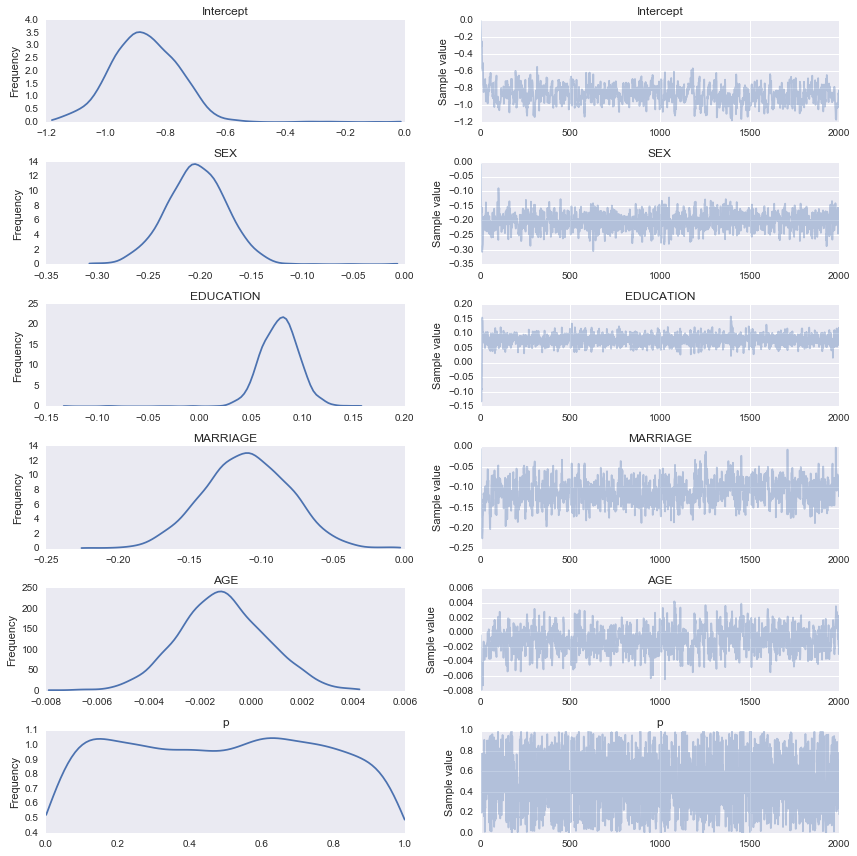

In [29]:
plt.figure(figsize=(7,7))
pm.traceplot(trace_logistic_model)
plt.tight_layout()

In [28]:
for coef in ['Intercept', 'SEX', 'AGE', 'MARRIAGE', 'EDUCATION']:
    print coef, ': ', np.mean(trace_logistic_model[coef])

Intercept :  -0.868505947247
SEX :  -0.203180955047
AGE :  -0.00112441348762
MARRIAGE :  -0.110143157352
EDUCATION :  0.0776307650623


In [31]:
import theano.tensor as T
def logistic(l):
    return 1 / (1+T.exp(-l))

## we are specifying more about this model, rather than having the computer pick for us
with pm.Model() as test_model:
    ## priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=100)
    sex_coef = pm.Normal('sex', mu=0, sd=100)
    marriage_coef = pm.Normal('marriage', mu=0, sd=100)
    y_hat = alpha + sex_coef * data['SEX'] + marriage_coef * data['MARRIAGE']
    ## likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(y_hat), observed=data['default'])
    start_MAP = pm.find_MAP()
    traces_new_logistic = pm.sample(2000, start=start_MAP, step=pm.NUTS(), njobs=-1, progressbar=True)



100%|██████████| 2000/2000 [04:33<00:00,  5.92it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d811ed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13eb30410>]], dtype=object)

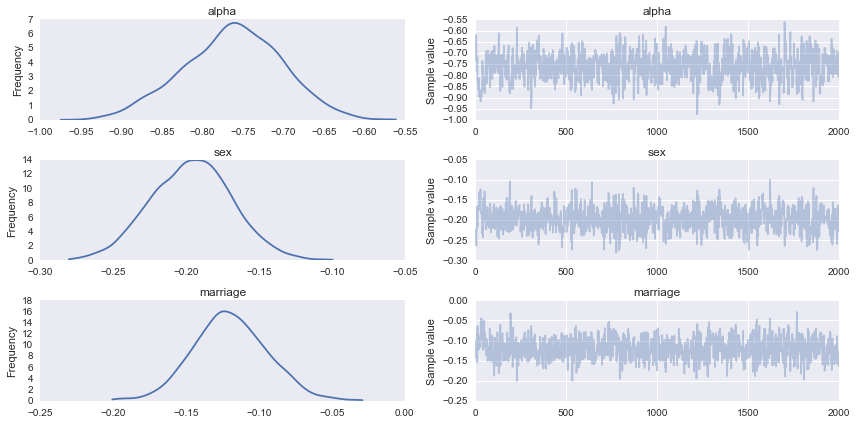

In [32]:
pm.traceplot(traces_new_logistic)

In [33]:
traces_new_logistic['sex'].mean()

-0.19630314809988006

In [35]:
data['MARRIAGE'].value_counts().apply(lambda x: x/float(len(data['MARRIAGE'])))

2    0.532133
1    0.455300
3    0.010767
0    0.001800
Name: MARRIAGE, dtype: float64

In [38]:

with pm.Model() as test_model:
    ## priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=100)
    ## sex is not a normal distribution. setting sex probability at 0.5
    sex_coef = pm.Bernoulli('sex', p=0.5)
#     sex_coef = pm.Normal('sex', mu=0, sd=100)
#     marriage_coef = pm.Normal('marriage', mu=0, sd=100)
    marriage_coef = pm.Categorical('marriage', p=np.array([0.53, 0.45, 0.01, 0.01]))
    y_hat = alpha + sex_coef * data['SEX'] + marriage_coef * data['MARRIAGE']
    ## likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(y_hat), observed=data['default'])
    start_MAP = pm.find_MAP()
    traces_new_logistic = pm.sample(2000, start=start_MAP, step=pm.NUTS(), njobs=-1, progressbar=True)

100%|██████████| 2000/2000 [01:11<00:00, 28.61it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14ce96710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13bfe1950>]], dtype=object)

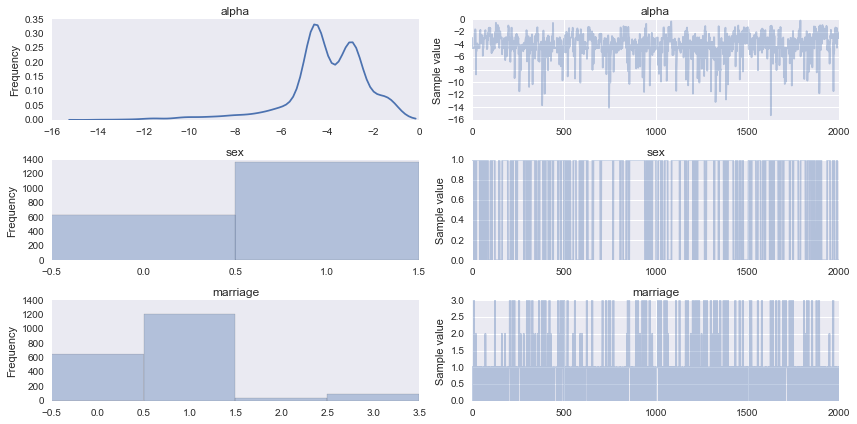

In [40]:
## this is vastly different, because we modeled these probabilities differently
pm.traceplot(traces_new_logistic)

In [41]:
traces_new_logistic['sex'].mean()

0.6835

In [42]:
traces_new_logistic['marriage'].mean()

0.79249999999999998

In [43]:
pm.summary(traces_new_logistic)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -4.027           1.832            0.084            [-7.761, -0.878]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -9.231         -4.581         -4.034         -2.883         -1.235


sex:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.683            0.465            0.027            [0.000, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          1.000          1.000          1.000


marriage:

  Mean             SD               MC Error         95% HPD interval
  ---------------------

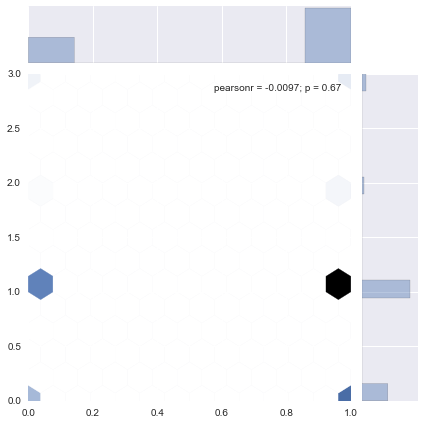

In [48]:
sns.jointplot(traces_new_logistic['sex'], traces_new_logistic['marriage'], kind='hex')

In [49]:
def predict(dictionary, model):
    coefs = sum([model[key] * value for key, value in dictionary.items()])
    coefs += model['alpha']
    return 1 / (1+T.exp(-coefs))

In [ ]:
def plotting_function(y_series):
    plt.scatter(np.linspace(0, len(y_series), len(y_series)), y_series)
    plt.hlines(y_series.mean(), 0, len(y_series))
    plt.xlabel('model iteration')
    plt.ylabel('p(y=1)')
    plt.show()

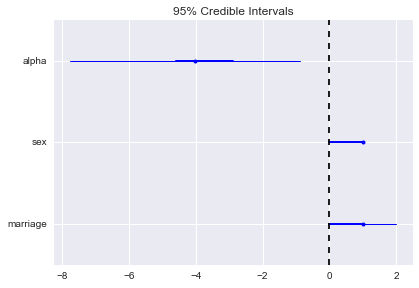

In [50]:
pm.forestplot(traces_new_logistic)

In [53]:
traces_new_logistic['sex'].min()

0

In [51]:
np.log(0.05)

-2.9957322735539909

In [52]:
len(traces_new_logistic)

2000